* XGBoost 버전 확인

In [1]:
import xgboost

print(xgboost.__version__)

0.90


### 파이썬 래퍼 XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

** 데이터 세트 로딩 **

In [2]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)


# y_label 1이면 악성malignant, 0이면 그냥 양성benign
cancer_df['target']= y_label
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)


(455, 30) (114, 30)


** 학습과 예측 데이터 세트를 DMatrix로 변환 **

In [5]:
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

** 하이퍼 파라미터 설정 **

In [6]:
params = { 'max_depth':3,
           'eta': 0.1,  # learning rate
           'objective':'binary:logistic',  # 결정하는 예측함수는 무엇으로? - 2진 분류 (디폴트 값이긴 함)
           'eval_metric':'logloss',  # 손실에 대한 걸 측정
           'early_stoppings':100
        }
num_rounds = 400  # 약한 학습기의 갯수

** 주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습 **

In [7]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval')]  # w 리스트는 아래 evals로


# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , 
                      dtrain=dtrain , 
                      num_boost_round=num_rounds , 
                      evals=wlist )

[0]	train-logloss:0.609685	eval-logloss:0.61352
[1]	train-logloss:0.540804	eval-logloss:0.547842
[2]	train-logloss:0.483755	eval-logloss:0.494247
[3]	train-logloss:0.434455	eval-logloss:0.447986
[4]	train-logloss:0.390549	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245152	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192183	eval-logloss:0.231556
[13]	train-logloss:0.177917	eval-logloss:0.22005
[14]	train-logloss:0.165221	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-log

** predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환 **

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


** get_clf_eval( )을 통해 예측 평가 **

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


** Feature Importance 시각화 **

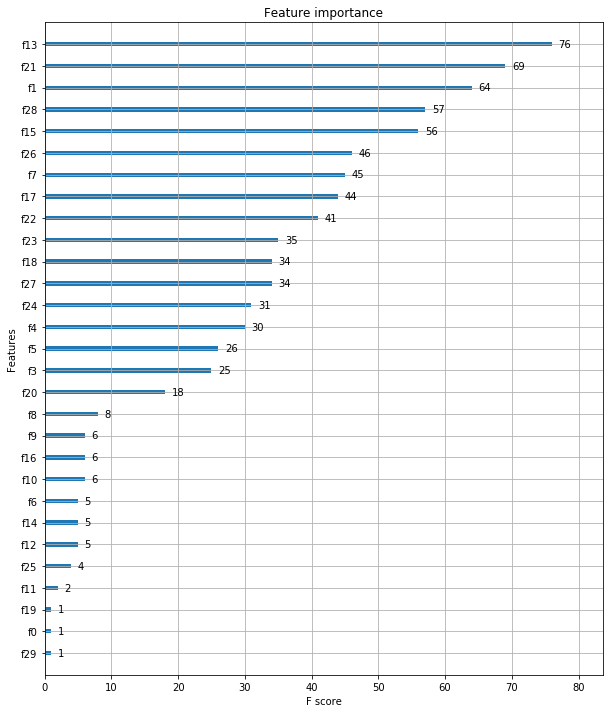

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

### 사이킷런 Wrapper XGBoost 개요 및 적용 

** 사이킷런 래퍼 클래스 임포트, 학습 및 예측 **

In [12]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

evals = [(X_test, y_test)]  # 원래는 검증 데이터를 넣어야하는데 예측 데이터를 넣었다. 데이터셋이 부족하니까 봐줘...

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, 
                early_stopping_rounds=400, 
                eval_set=evals, 
                eval_metric="logloss",  
                verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 400 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [13]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


** early stopping을 100으로 설정하고 재 학습/예측/평가 **

In [14]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, 
                eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[211]에서 0.085593가 나오고 정점을 찍는다. 그 이후 100회를 반복할 동안 00.85593을 넘기지 못했으니 종료

In [15]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


** early stopping을 10으로 설정하고 재 학습/예측/평가 **

In [16]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [17]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

evals = [(X_train, y_train)]  # 원래는 검증 데이터를 넣어야하는데 예측 데이터를 넣었다. 데이터셋이 부족하니까 봐줘...

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, 
                early_stopping_rounds=400, 
                eval_set=evals, 
                eval_metric="logloss",  
                verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


[0]	validation_0-logloss:0.609685
Will train until validation_0-logloss hasn't improved in 400 rounds.
[1]	validation_0-logloss:0.540804
[2]	validation_0-logloss:0.483755
[3]	validation_0-logloss:0.434455
[4]	validation_0-logloss:0.390549
[5]	validation_0-logloss:0.354145
[6]	validation_0-logloss:0.321222
[7]	validation_0-logloss:0.292592
[8]	validation_0-logloss:0.267467
[9]	validation_0-logloss:0.245152
[10]	validation_0-logloss:0.225694
[11]	validation_0-logloss:0.207937
[12]	validation_0-logloss:0.192183
[13]	validation_0-logloss:0.177917
[14]	validation_0-logloss:0.165221
[15]	validation_0-logloss:0.153622
[16]	validation_0-logloss:0.14333
[17]	validation_0-logloss:0.133985
[18]	validation_0-logloss:0.125599
[19]	validation_0-logloss:0.117286
[20]	validation_0-logloss:0.109688
[21]	validation_0-logloss:0.102975
[22]	validation_0-logloss:0.097068
[23]	validation_0-logloss:0.091428
[24]	validation_0-logloss:0.086335
[25]	validation_0-logloss:0.081311
[26]	validation_0-logloss:0.0768

In [18]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


#### evals 비교하기

evals =  [(X_test, y_test)] 였을 때는 아래처럼 나왔었다!

정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


### 넘파이라서 칼럼 명을 알 수가 없으니 순서로 넣은 거예용 (피쳐 순서)

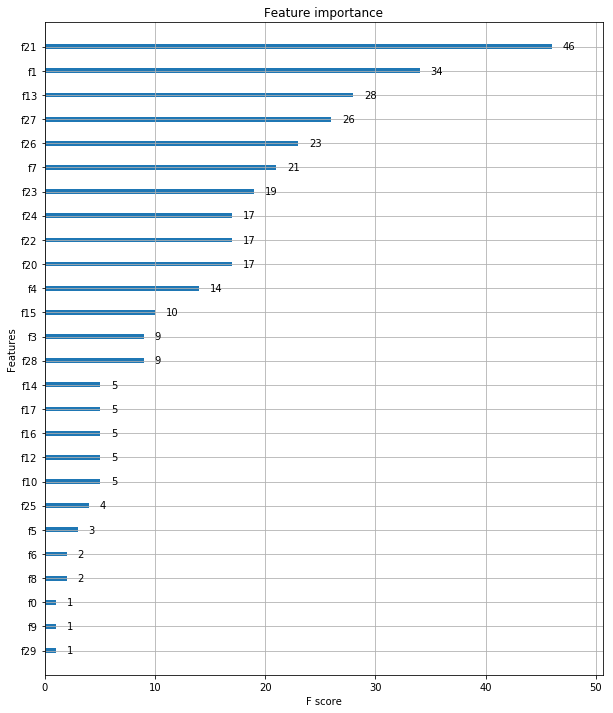

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)